### Packages

In [1]:
cd '/h/ama/workspace/ama-at-vector/best-mix'

/scratch/ssd001/home/ama/workspace/ama-at-vector/best-mix


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.models as models
import matplotlib.pyplot as plt
import math
import pickle

from mixup import mixup_graph

os.environ['KMP_DUPLICATE_LIB_OK']='True'
%matplotlib inline

In [4]:
def print_fig(input, target=None, title=None, save_dir=None):
    fig, axes = plt.subplots(1,len(input),figsize=(3*len(input),3))
    if title:
        fig.suptitle(title, size=16)
    if len(input) == 1 :
        axes = [axes]
        
    for i, ax in enumerate(axes):
        if len(input.shape) == 4:
            ax.imshow(input[i].permute(1,2,0).numpy())
        else :
            ax.imshow(input[i].numpy(), cmap='gray', vmin=0., vmax=1.)
        
        if target is not None:
            output = net((input[i].unsqueeze(0) - mean)/std)
            loss = criterion(output, target[i:i+1])
            ax.set_title("loss: {:.3f}\n pred: {}\n true : {}".format(loss, CIFAR100_LABELS_LIST[output.max(1)[1][0]], CIFAR100_LABELS_LIST[target[i]]))
        ax.axis('off')
    plt.subplots_adjust(wspace = 0.1)
    
    if save_dir is not None:
        plt.savefig(save_dir, bbox_inches = 'tight',  pad_inches = 0)
        
    plt.show()

### Model, Data, Saliency

In [5]:
''' Model '''
resnet = models.resnet18(pretrained=True)
mean = torch.tensor([0.485, 0.456, 0.406])
std = torch.tensor([0.229, 0.224, 0.225])
mean_torch = mean.unsqueeze(0).unsqueeze(-1).unsqueeze(-1)
std_torch = std.unsqueeze(0).unsqueeze(-1).unsqueeze(-1)

resnet.eval()
criterion = nn.CrossEntropyLoss()

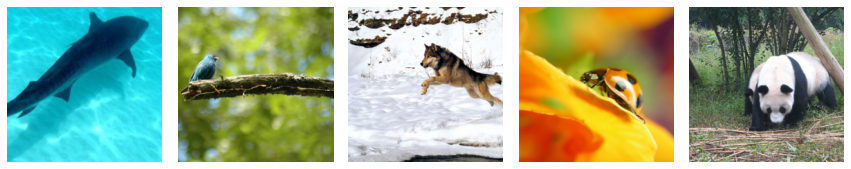

In [6]:
''' Data '''
img_exists = False 
sample_num = 5

if img_exists:
    # I used this codes to load data
    test_transform = transforms.Compose([
          transforms.Resize(256),
          transforms.CenterCrop(224),
          transforms.ToTensor(),
          transforms.Normalize(mean=mean, std=std)])

    sample_num = 5
    valdir = os.path.join('/Users/janghyun/Documents/Datasets/ImageNet', 'val')
    val_dset = datasets.ImageFolder(valdir, test_transform)
    val_loader = torch.utils.data.DataLoader(val_dset, batch_size=sample_num, shuffle=False, num_workers=2)

    ### Selected Examples
    input_sp = torch.stack([val_dset[3*50][0], val_dset[14*50][0], val_dset[269*50+2][0], val_dset[301*50+0][0], val_dset[388*50+2][0]], dim=0)
    targets = torch.tensor([val_dset[3*50][1], val_dset[14*50][1], val_dset[269*50+2][1], val_dset[301*50+0][1], val_dset[388*50+2][1]])

else:
    # I saved the processed images at figures folder
#     with open('figures/sample.data', 'rb') as file:
    with open('/h/ama/workspace/ama-at-vector/best-mix/figures/sample.data', 'rb') as file:
        input_sp, targets = pickle.load(file)
    
print_fig((input_sp * std_torch + mean_torch)[:sample_num])

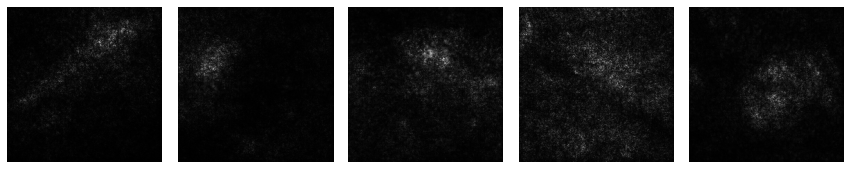

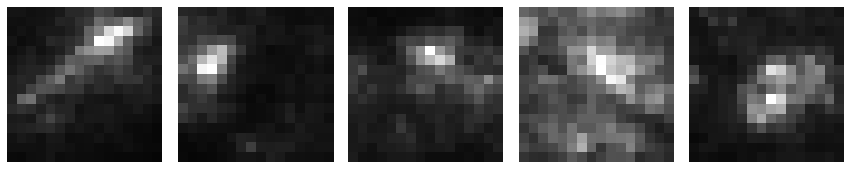

In [7]:
''' Saliency '''
input_var = input_sp[:sample_num].clone().detach().requires_grad_(True)
output = resnet(input_var)
loss = criterion(output, targets[:sample_num])
loss.backward()

unary = torch.sqrt(torch.mean(input_var.grad **2, dim=1))  
unary = unary / unary.view(sample_num, -1).max(1)[0].view(sample_num, 1, 1)
print_fig(unary)

unary16 = F.avg_pool2d(unary, 224//16)
unary16 = unary16 / unary16.view(sample_num, -1).max(1)[0].view(sample_num, 1, 1)
print_fig(unary16)

### Puzzle Mix

/scratch/ssd001/home/ama/workspace/ama-at-vector/best-mix/mixup.py:295: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1639180549130/work/torch/csrc/utils/tensor_new.cpp:201.)
  mask = torch.tensor(mask, dtype=torch.float32, device=device)


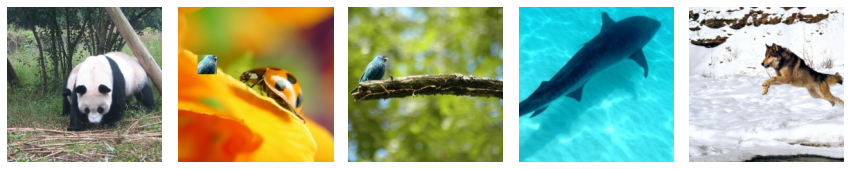

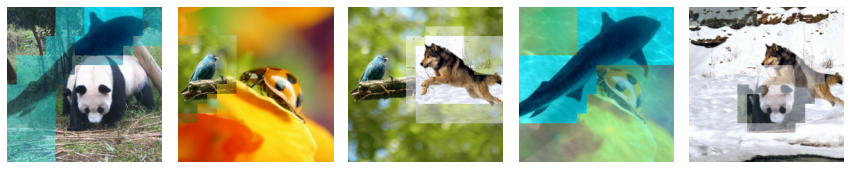

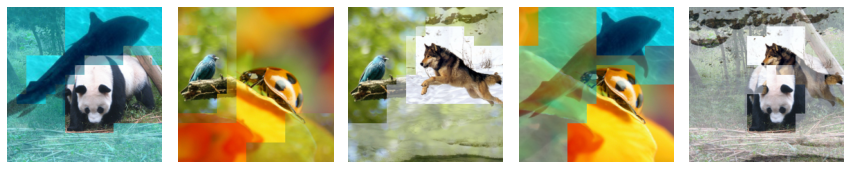

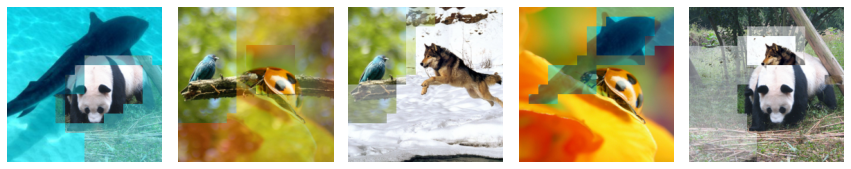

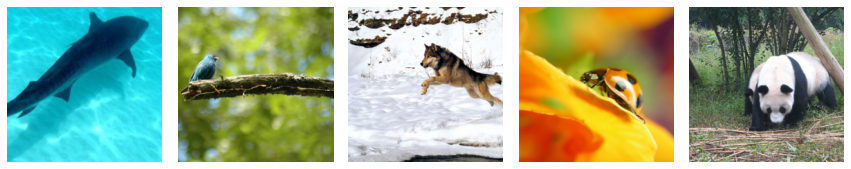

In [13]:
''' Alpha Sweep'''
indices = [4,3,1,0,2]

n_labels = 3
block_num = 16

alpha = 0.5
beta = 0.8
gamma = 1.0
eta = 0.2

transport = False

for alpha in np.linspace(0,1,5):
    output = mixup_graph(input_sp, unary, indices=indices, n_labels=n_labels,
                         block_num=block_num, alpha=np.array([alpha]).astype('float32'), beta=beta, gamma=gamma, eta=eta,
                         neigh_size=2, mean=mean_torch, std=std_torch, 
                         transport=transport, t_eps=0.8, t_size=16, 
                         device='cpu')

    print_fig(output[0] * std_torch + mean_torch)

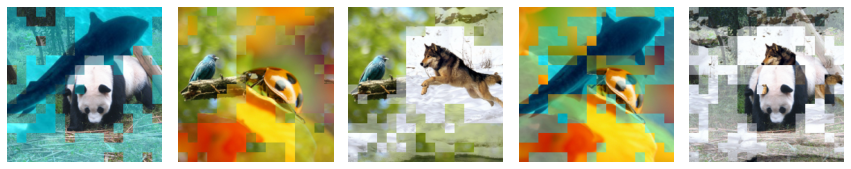

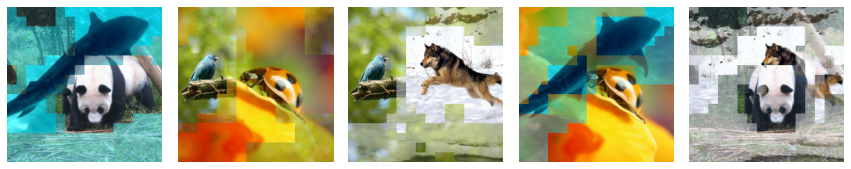

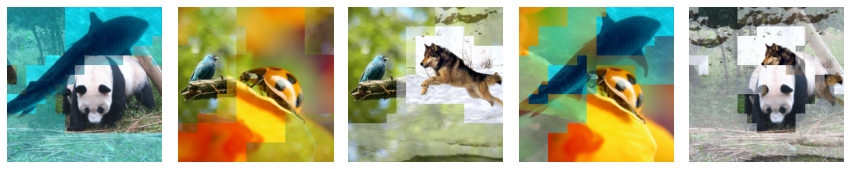

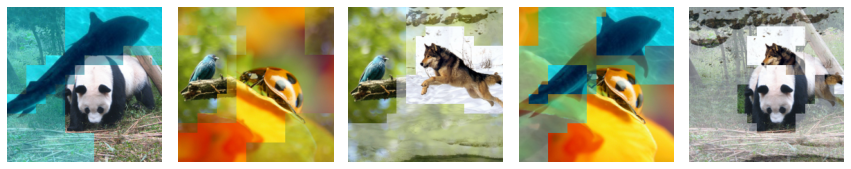

In [14]:
''' Beta Sweep'''
indices = [4,3,1,0,2]

n_labels = 3
block_num = 16

alpha = 0.5
gamma = 0.
eta = 0.2

transport = False

for beta in np.linspace(0,0.8,4):
    output = mixup_graph(input_sp, unary, indices=indices, n_labels=n_labels,
                         block_num=block_num, alpha=np.array([alpha]).astype('float32'), beta=beta, gamma=gamma, eta=eta,
                         neigh_size=2, mean=mean_torch, std=std_torch, 
                         transport=transport, t_eps=0.8, t_size=16, 
                         device='cpu')

    print_fig(output[0] * std_torch + mean_torch)

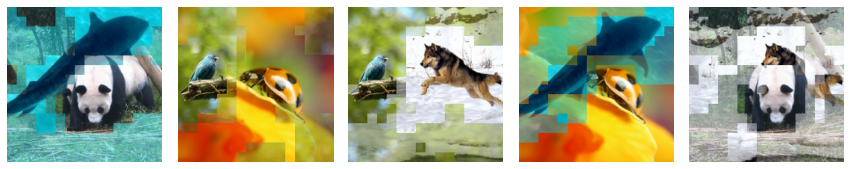

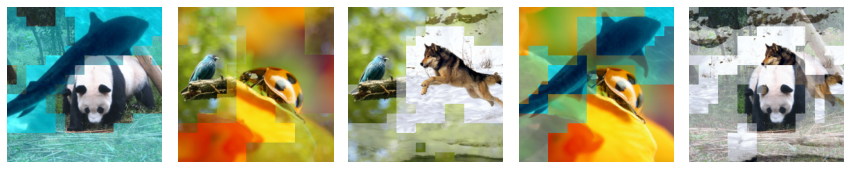

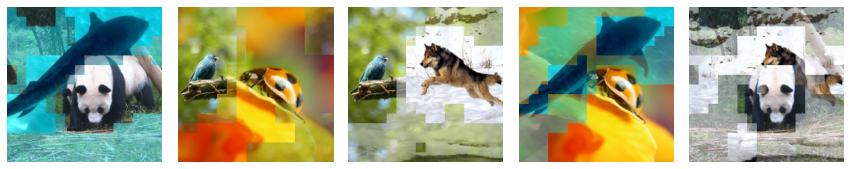

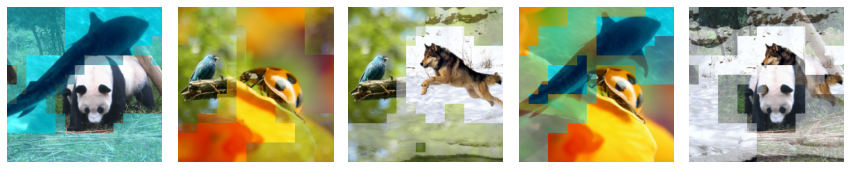

In [15]:
''' Gamma Sweep'''
indices = [4,3,1,0,2]

n_labels = 3
block_num = 16

alpha = 0.5
beta = 0.2
eta = 0.2

transport = False

for gamma in np.linspace(0,2,4):
    output = mixup_graph(input_sp, unary, indices=indices, n_labels=n_labels,
                         block_num=block_num, alpha=np.array([alpha]).astype('float32'), beta=beta, gamma=gamma, eta=eta,
                         neigh_size=2, mean=mean_torch, std=std_torch, 
                         transport=transport, t_eps=0.8, t_size=16, 
                         device='cpu')

    print_fig(output[0] * std_torch + mean_torch)

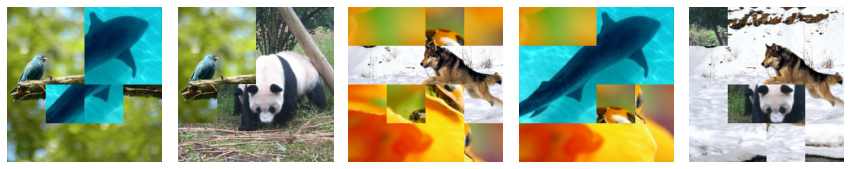

In [14]:
''' Transport '''
indices = [1,4,3,0,2]

n_labels = 2
block_num = 4

alpha = 0.4
beta = 0.2
gamma = 1.0
eta = 0.2

transport = True
t_eps=0.2
t_size=224//block_num

output = mixup_graph(input_sp.cuda(), unary.cuda(), indices=indices, n_labels=n_labels,
                     block_num=block_num, alpha=np.array([alpha]).astype('float32'), beta=beta, gamma=gamma, eta=eta,
                     neigh_size=2, mean=mean_torch.cuda(), std=std_torch.cuda(), 
                     transport=transport, t_eps=t_eps, t_size=t_size, 
                     device='cuda')

print_fig(output[0].cpu() * std_torch + mean_torch)

/scratch/ssd001/home/ama/workspace/ama-at-vector/best-mix/mixup.py:295: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1639180549130/work/torch/csrc/utils/tensor_new.cpp:201.)
  mask = torch.tensor(mask, dtype=torch.float32, device=device)


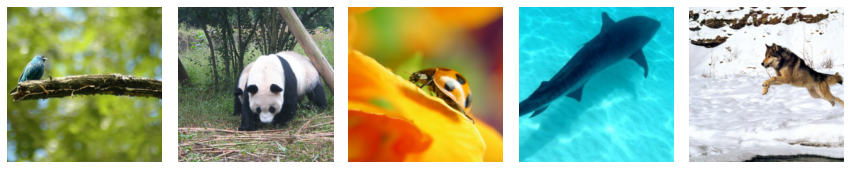

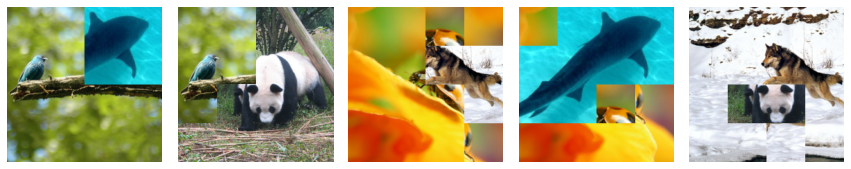

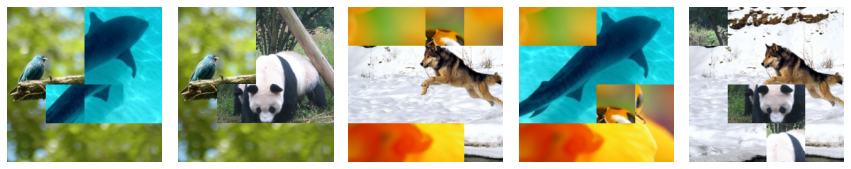

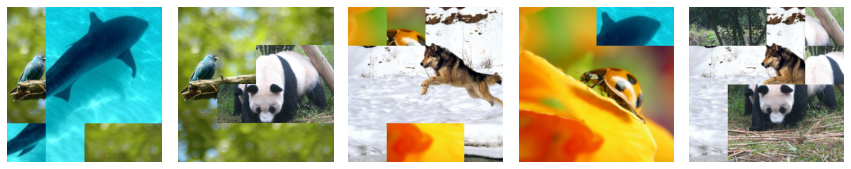

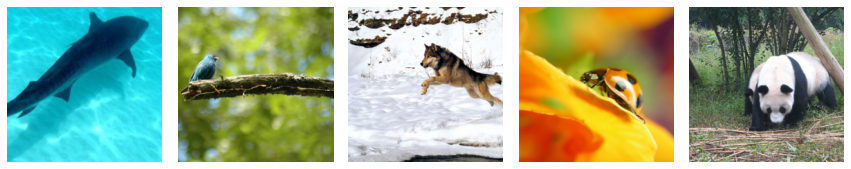

In [8]:
''' Transport '''
indices = [1,4,3,0,2]

n_labels = 2
block_num = 4

alpha = 0.4
beta = 0.2
gamma = 1.0
eta = 0.2

transport = True
t_eps=0.2
t_size=224//block_num


for _alpha in np.linspace(0,1,5):
    output = mixup_graph(input_sp.cuda(), unary.cuda(), indices=indices, n_labels=n_labels,
                         block_num=block_num, alpha=np.array([_alpha]).astype('float32'), beta=beta, gamma=gamma, eta=eta,
                         neigh_size=2, mean=mean_torch.cuda(), std=std_torch.cuda(), 
                         transport=transport, t_eps=t_eps, t_size=t_size, 
                         device='cuda')

    print_fig(output[0].cpu() * std_torch + mean_torch)